In [124]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15,10)
from sklearn.metrics import mean_squared_error
import sys
from pathlib import Path
import sys
sys.path.append("../")
from src.model_testing import *

import plotly.graph_objects as go

import pickle


In [125]:
#'country' or 'state'
division = 'country'
region = 'United States'
#'ConfirmedCases' or 'ConfirmedDeaths'
prediction = 'ConfirmedCases'

full_df = get_covid_data()
if division == 'country':
    df = full_df[(full_df['Jurisdiction'] == 'NAT_TOTAL') & (full_df['CountryName'] == region)][:-1]
elif division == 'state':
    df = full_df[(full_df['Jurisdiction'] == 'STATE_TOTAL') & (full_df['RegionName'] == region)][:-1]

#remove unneeded columns and set date as index (necessary for SARIMA model)
df = df.iloc[:,5:]
cols = [c for c in df.columns if (c.lower()[-10:] != 'fordisplay') and (c.lower()[-4:] != 'flag')]
df = df[cols]
df = df.set_index('Date', drop=True)

#drop columns with no data and forward-fill missing data after first non nan value
df = df.dropna(how='all', axis=1)
df = df.fillna(method = 'ffill')

#remove days before first infections
df = df[df[prediction] > 0]

#train-test split
train_df = df[df.index < '2020-12-01']
test_df = df[(df.index >= '2020-12-01') & (df.index < '2021-01-01')]

train = train_df[prediction]
test = test_df[prediction]
true = df[prediction]
train.index.freq = 'D'
test.index.freq = 'D'
true.index.freq = 'D'

additional_regressors = df.drop(columns = [col for col in df.columns if col in ['ConfirmedDeaths','ConfirmedCases']])

# Plotting new cases:
We see below that there is a weekly seasonality to the diagnosis of new daily cases.

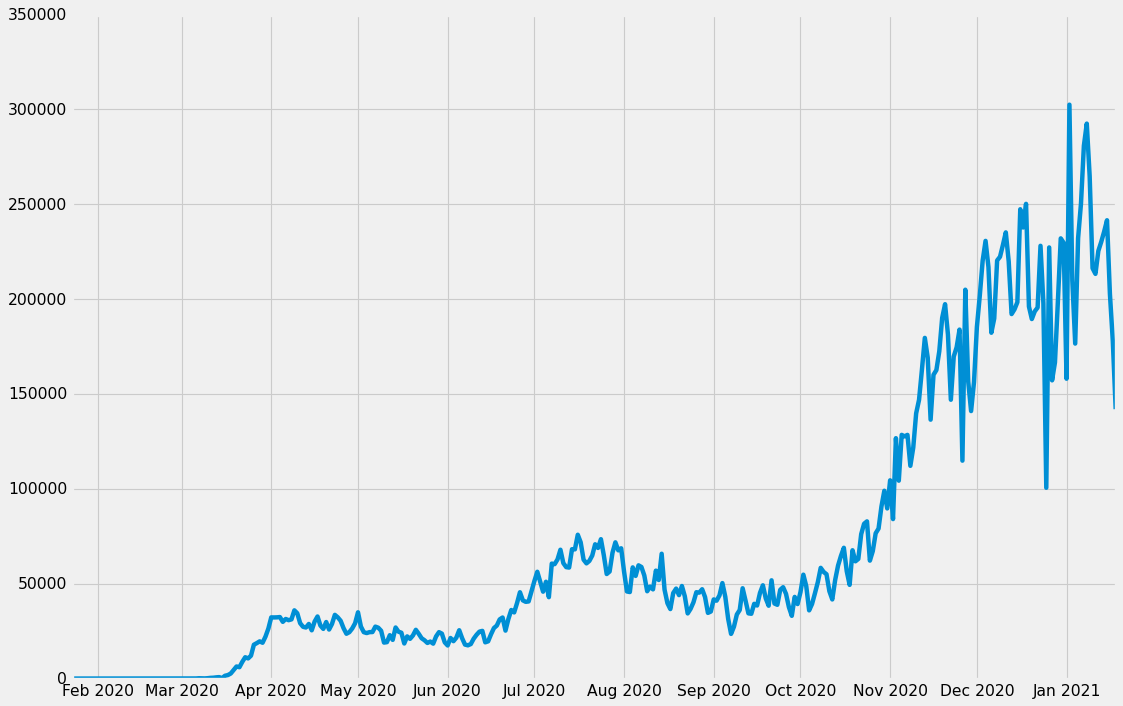

In [126]:
# differencing of one day turns total cases into daily new cases
# by tracking the change rather than the total
plt.plot(df[prediction].diff(1)[:])  

Above, we see a weekly seasonality in the decomposition.  We also see exploding variance in the residuals after October.  We also see that the decomposition failed to revmove the seasonality in the residuals for the first half of the year.

Lets see if we can get a better decomposition

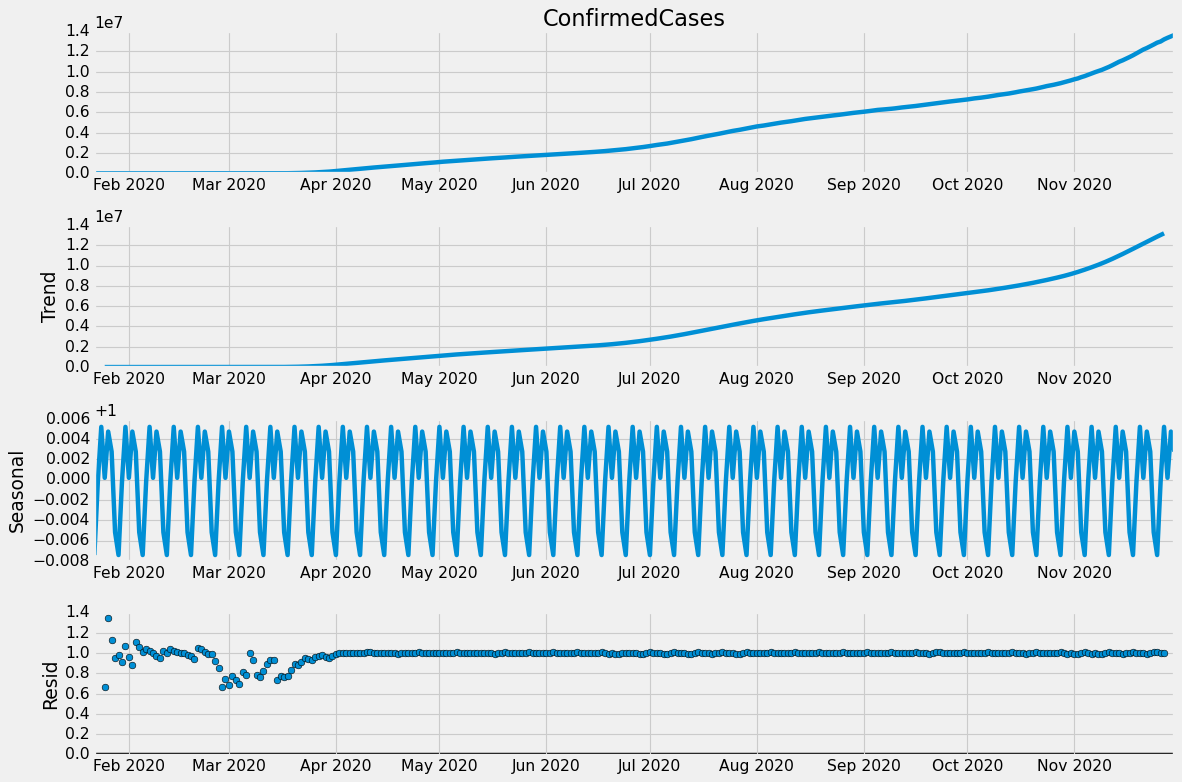

In [127]:
results = seasonal_decompose(train_df['ConfirmedCases'],two_sided = True, model='multiplicative')
results.plot()
plt.show()

Let's take a look at this seasonality.  Where is it coming from?  


The below bar plot of average infections per day of the week suggests that test results are most often reported on Mondays and least often reported on Wednesdays.  The number of reports seems to escalate steadily from Wednesday to Monday. It seems unlikely that these numbers represent the days people are actually infected on.  I imagine the data is entered sometime after tests come back, which is between 2 and 5 days after testing.  PCR tests are most accurate 5+ days after exposure, so we can assume reported cases lag by 7-10 days.  I would guess that the greater number of reports on Mondays has to do with either the workflow patterns in laboratories, or the patterns of when people tend to go in for tests. 

NOTE: y-axis begins at 3.6m.

Text(0.5, 0, 'Day of the Week')

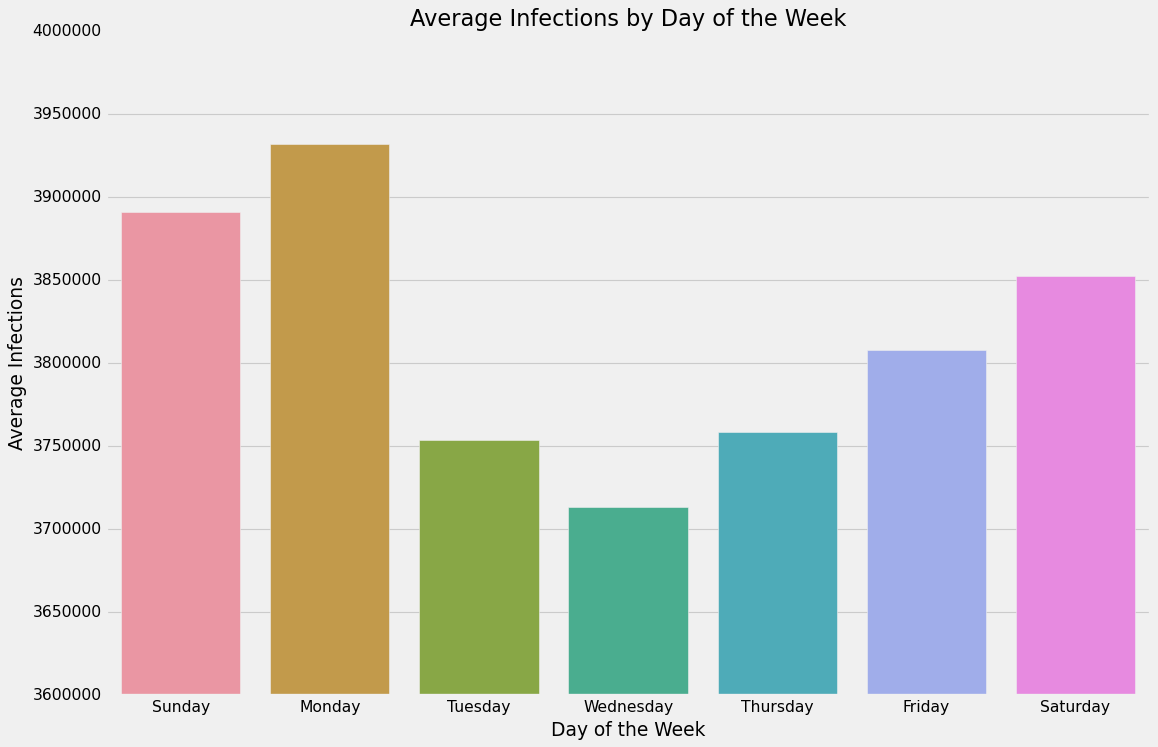

In [128]:
import seaborn as sns
ax = plt.subplot()
sns.barplot(x=train_df.index.day_name(), y=train_df[prediction].values, ax=ax, ci=False,
           order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
ax.set_ylim([3600000,4000000])
ax.set_title('Average Infections by Day of the Week')
ax.set_ylabel('Average Infections')
ax.set_xlabel('Day of the Week')

# SARIMA

In [129]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In our ACF plot we see the effects of our weekly seasonality at 7, 14, and 21 days.  We also see jumps in autocorrelation in the days before and after those.  My guess is that testing is most often done on weekends.  Let's do a visual inspection to see if that is true.

In [130]:
cbrt_train =  np.cbrt(train)
train = train_df[prediction]
test = test_df[prediction]
true = df.loc[df.index < '2021-01-01',prediction]
train.index.freq = 'D'
test.index.freq = 'D'
true.index.freq = 'D'

# Testing for Stationarity

In [131]:
from statsmodels.tsa.stattools import adfuller


First, let's see if we can remove the seasonality with seasonal lagged differencing.

(2.436980490828137,
 0.9990266638079002,
 17,
 327,
 {'1%': -3.45050711373316,
  '5%': -2.8704195794076743,
  '10%': -2.571500856923753},
 7058.3231084417475)

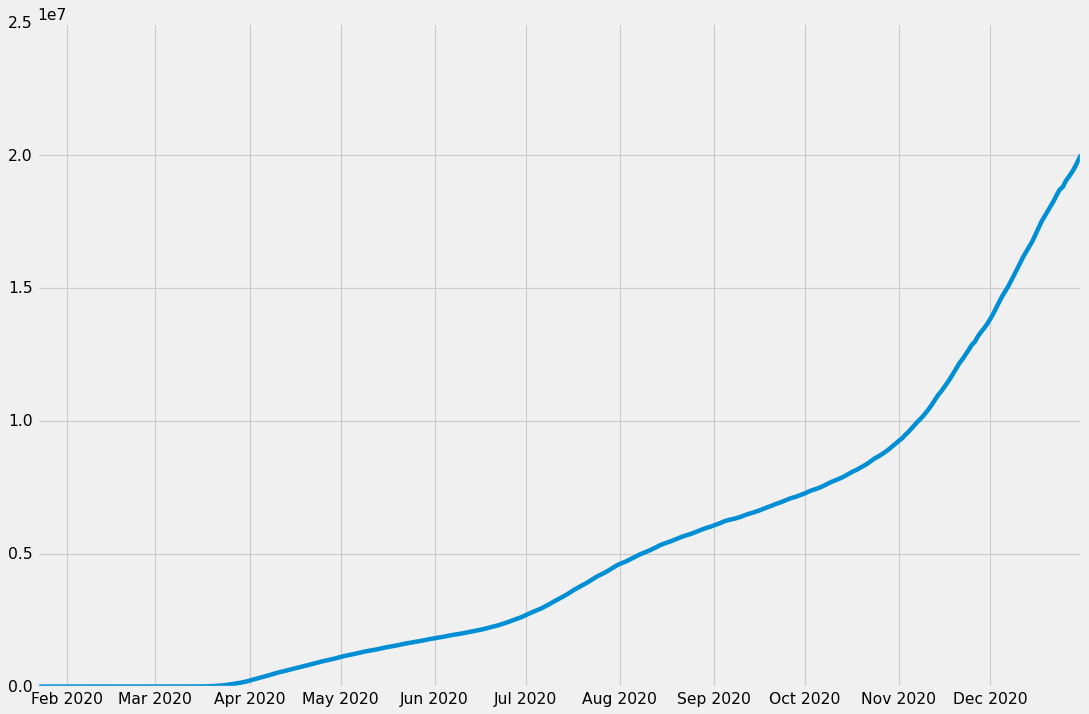

In [132]:
plt.plot(true)
adfuller(true)


(-1.1687452659022421,
 0.9167133770561104,
 8,
 335,
 {'1%': -3.986051060037305,
  '5%': -3.4236773953644564,
  '10%': -3.1348037786230356},
 7111.244570941536)

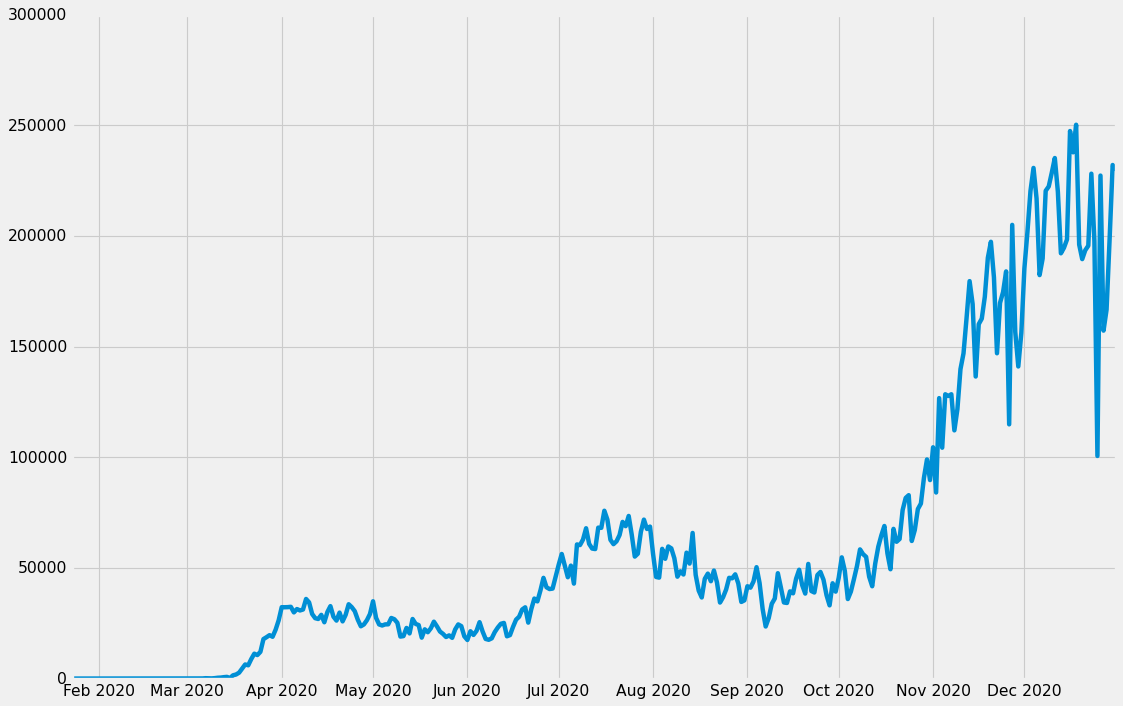

In [133]:
train_diff = true.diff(1).dropna()
plt.plot(train_diff)
adresults = adfuller(train_diff, autolag = 'BIC', regression = 'ct')
adresults

Above, we do a first order differencing, which, as mentioned, transforms cumulative cases to daily new cases.  This makes the data stationary at a lag of 11.  We will remember this number for our AM model. 

Below we will try a second order differencing.

(-1.1401194365821312,
 0.9220700491178023,
 12,
 325,
 {'1%': -3.986898741156122,
  '5%': -3.4240857927792443,
  '10%': -3.135043504014565},
 7005.1585255956115)

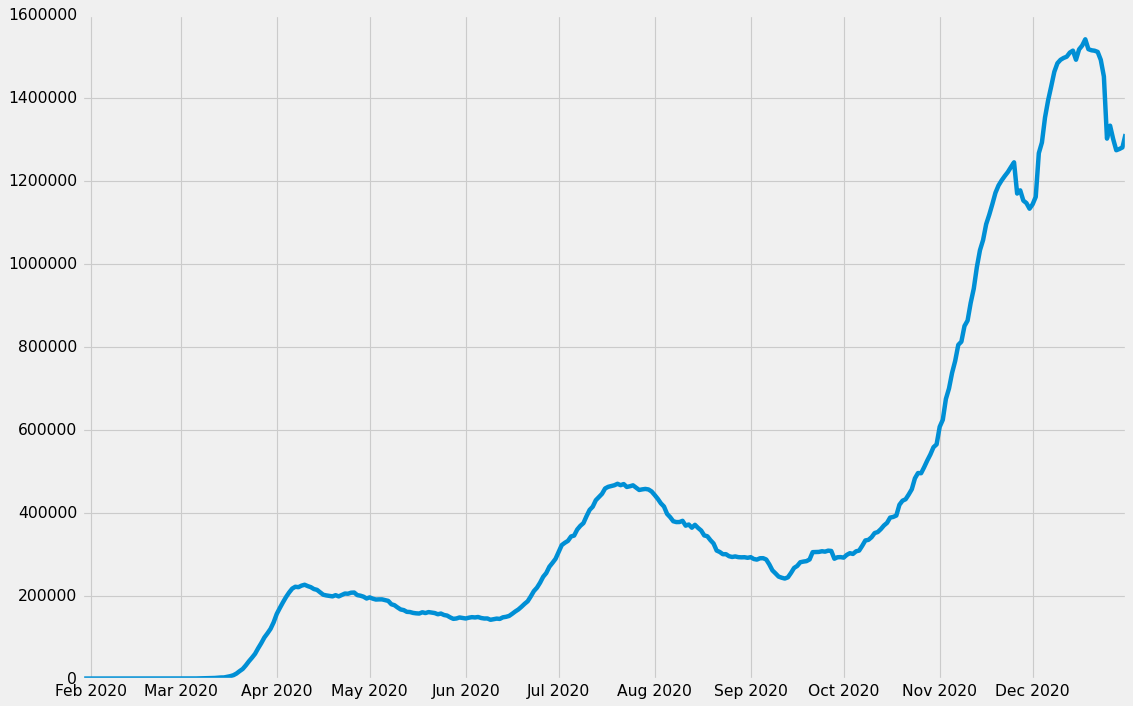

In [134]:
train_diff_week = true.diff(7).dropna()
plt.plot(train_diff_week)
adresults = adfuller(train_diff_week, autolag = 'BIC', regression = 'ct')
adresults

Let's try a second order differencing to remove the trend as well.  This will be equivalent to the ARIMA model having a difference of 1 and the seasonal adjustment a difference of 7.

(-4.015246443419216,
 0.00836477720832962,
 11,
 325,
 {'1%': -3.986898741156122,
  '5%': -3.4240857927792443,
  '10%': -3.135043504014565},
 6980.080282764065)

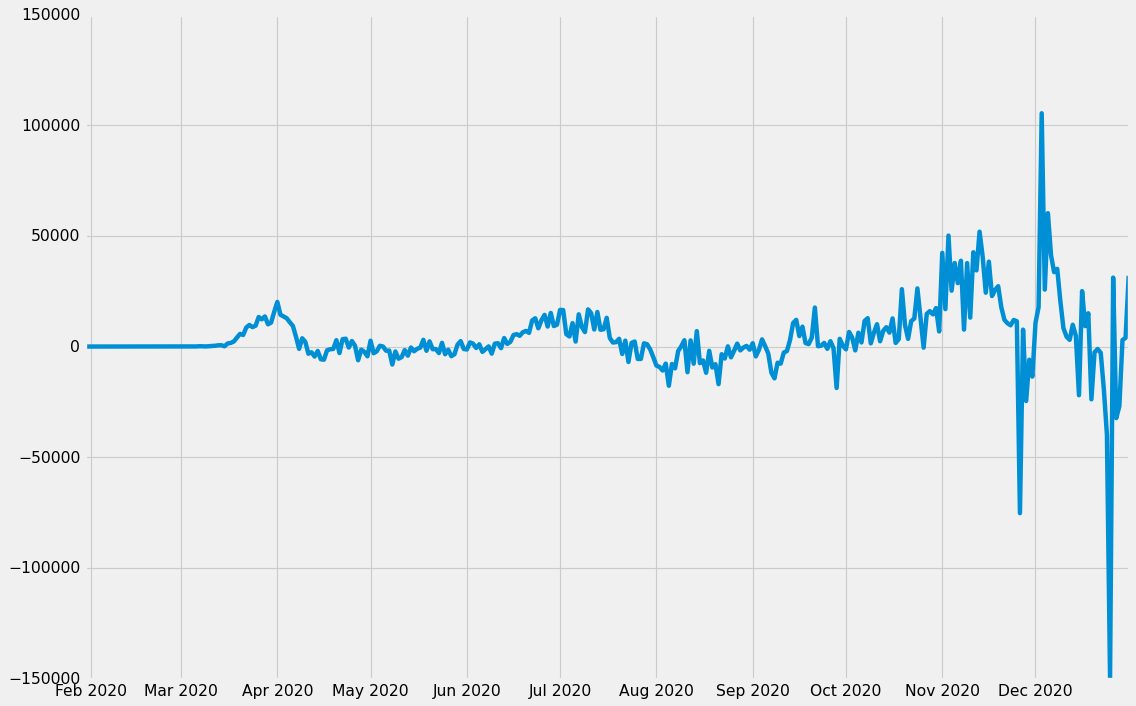

In [135]:
train_diff_week2 = true.diff(7).diff(1).dropna()
plt.plot(train_diff_week2)
adresults = adfuller(train_diff_week2, autolag = 'BIC', regression = 'ct')
adresults

The second order differencing removed the trend from our data, but the variance is not constant yet.  Another trick we can try is a cube root transformation to reduce the variance change.

(-4.26022610130634,
 0.003624471464381529,
 13,
 323,
 {'1%': -3.9870746386005544,
  '5%': -3.4241705267641804,
  '10%': -3.135093239060335},
 -125.94663742822722)

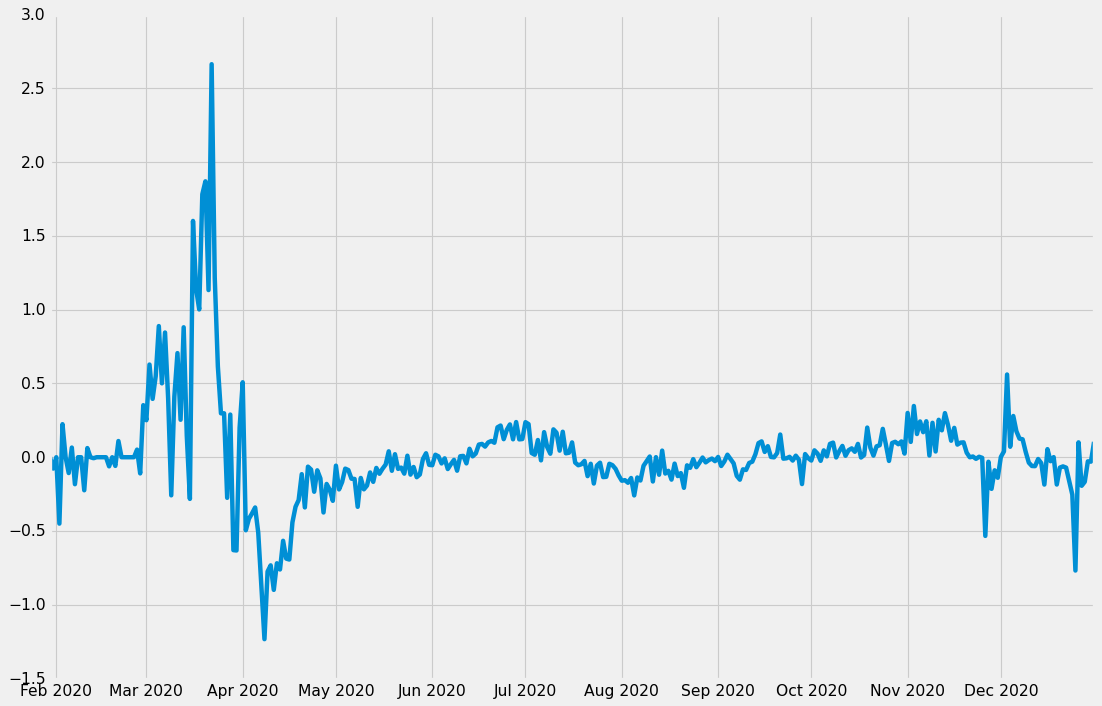

In [136]:
rolling_diff2 = np.cbrt(true).diff(7).diff(1).dropna()
plt.plot(rolling_diff2)
adresults = adfuller(rolling_diff2, autolag = 'BIC', regression = 'ct')
adresults

We pass the Dicky-Fuller and the change in variance does not seem to trend over our data set.  It's pretty localized to March and April.  We will cbrt transform our data and tell our model to use a seasonal lag of 7 days and an ARMA difference of 1 day lag.  Let's use ACF and a PACF charts to find clues to the best AR and MA lags.

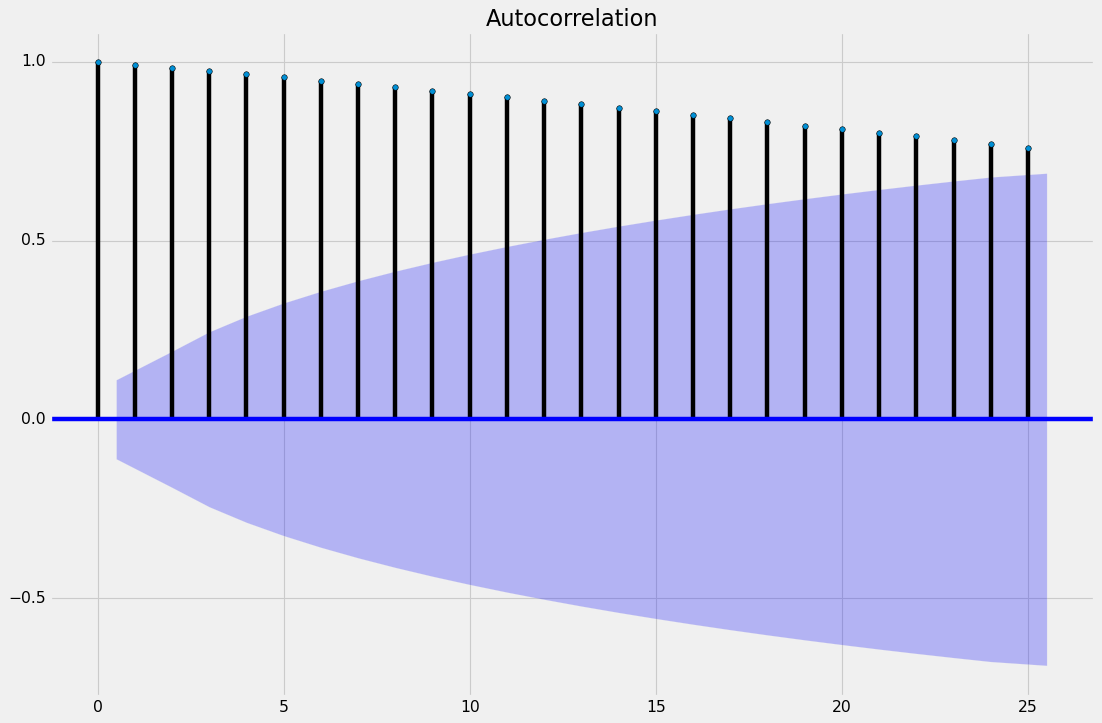

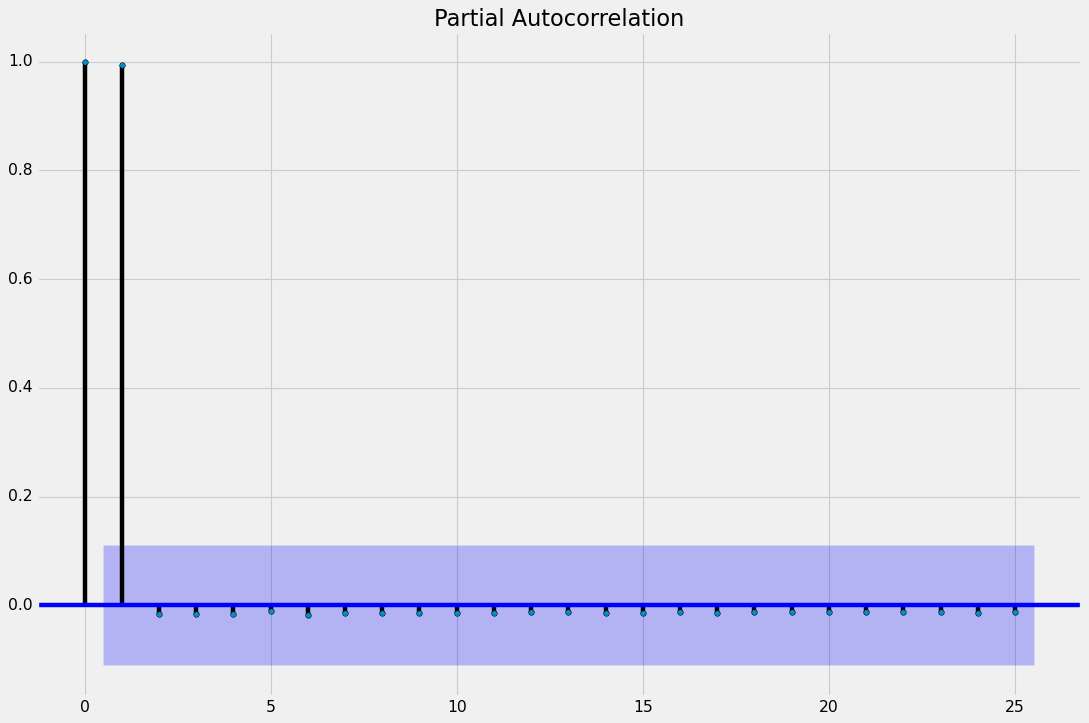

In [137]:
plot_acf(cbrt_train)
plot_pacf(cbrt_train)
plt.show()

The spike at lag 1 in the PACF tells us we want an AR setting of 1 and the gradual drop off of the ACF suggests we set the MA lag to 0.

We will start with a simpler model below, without dealing with the seasonality and built to a more complex model.

simple arima mean percent error:  0.06756441485435623


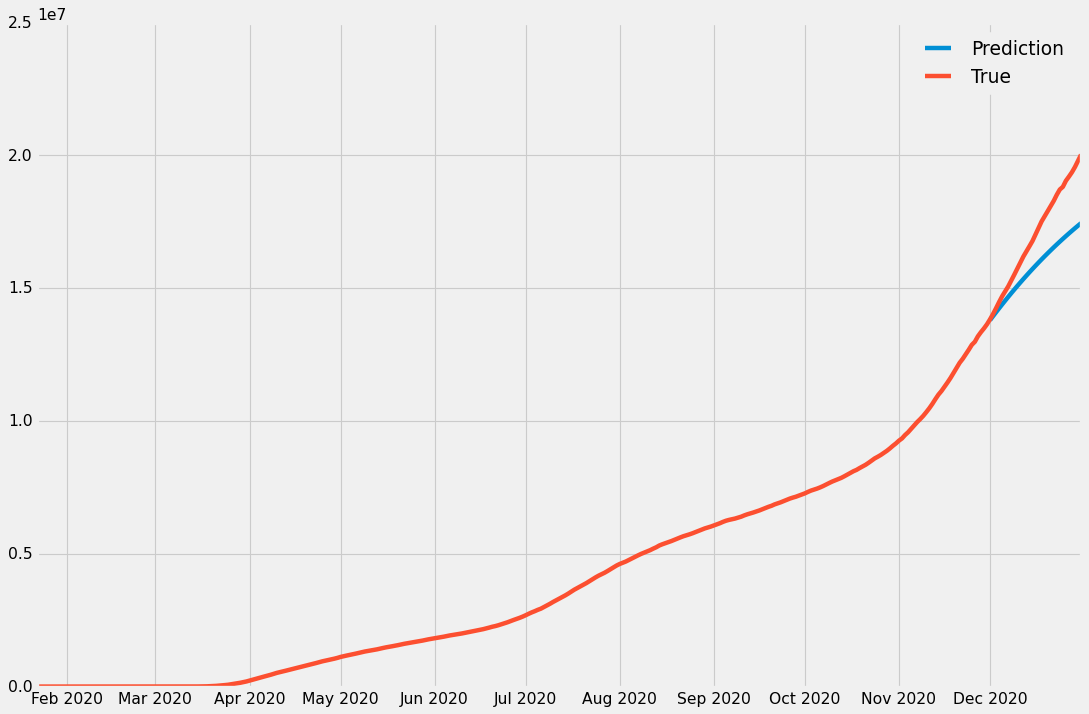

In [138]:
arimamodel = SARIMAX(cbrt_train, order = (1,1,0))
fit_model = arimamodel.fit()
yhat = fit_model.forecast(len(test))
# undo the cube root in order to compare to the test data
yhat = yhat**3
mpe = mean_percent_error(test,yhat)
print('simple arima mean percent error: ', mpe)
plt.plot(yhat, label = 'Prediction')
plt.plot(true, label = 'True')
plt.legend()
plt.show()

This is fine for a start, but lets try adding the seasonal element, a SARIMA model.

simple arima mean percent error:  0.030173698466220648


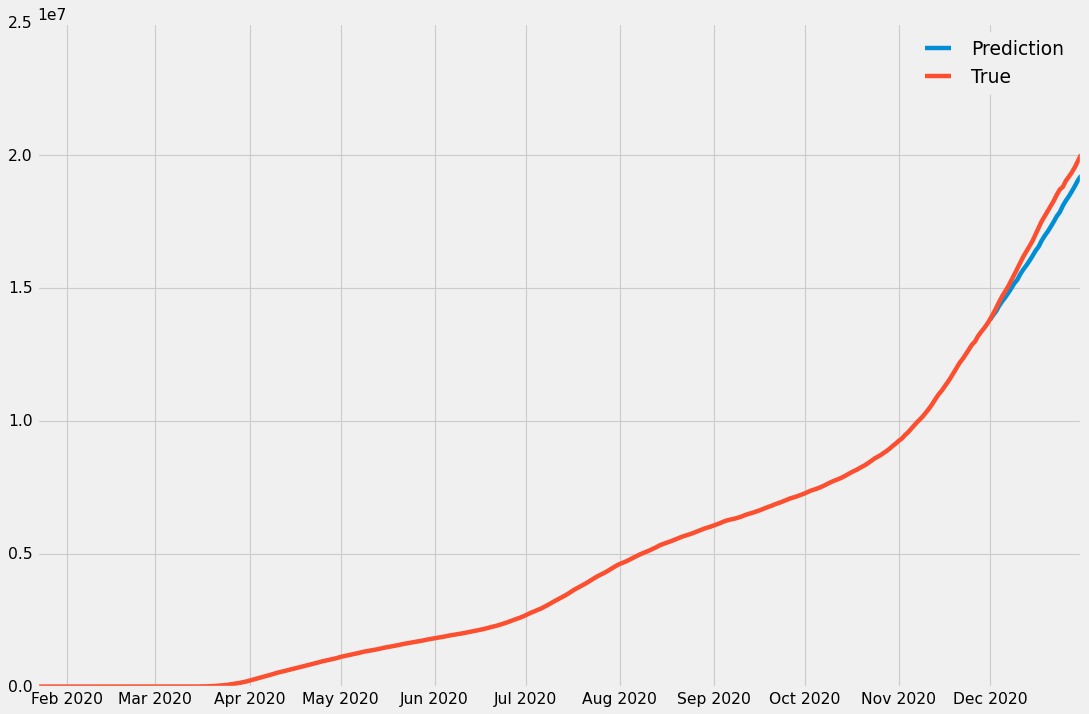

In [139]:
arimamodel = SARIMAX(cbrt_train, order = (1,1,0), seasonal_order = (1,1,0,7))
fit_model = arimamodel.fit()
yhat = fit_model.forecast(len(test))
# undo the cube root in order to compare to the test data
yhat = yhat**3
mpe = mean_percent_error(test,yhat)
print('simple arima mean percent error: ', mpe)
plt.plot(yhat, label = 'Prediction')
plt.plot(true, label = 'True')
plt.legend()
plt.show()

This is much better.  Our model is only off by about 3% for the month of December and the beginning of January.

A closer examination of our data shows certain points where the trend changes.  I am seeing the beginning of April, July, middle of October, and December.  I wonder if those line up with holidays or spreading events at some lag.  Perhaps the end of the March lockdown, beginning of summer, start of school, and Thanksgiving? Adding holidays or events where people gather might help the model account for these.

In [140]:
test_results = pd.DataFrame(columns = ['MPE'])
for p in range(0,4):
    for d in range(1,3):
        for q in range(0,4):
            for P in range(0,4):
                for D in range(1,3):
                    for Q in range(0,4):
                        model = SARIMAX(cbrt_train, order =(p,d,q), seasonal_order = (P,D,Q,7),
                                       freq = 'D')
                        fit_model = model.fit(maxiter = 200, disp = False)
                        yhat = fit_model.forecast(len(test))
                        yhat = yhat**3
                        ind = f'order = ({p},{d},{q}), seasonal_order = ({P},{D},{Q},7)'
                        mpe = mean_percent_error(test,yhat)
                        print(f'trying {ind}, MPE = {mpe}')
                        test_results.loc[ind,'MPE'] = mpe

test_results.min()

trying order = (0,1,0), seasonal_order = (0,1,0,7), MPE = 0.024068263494324473
trying order = (0,1,0), seasonal_order = (0,1,1,7), MPE = 0.029540479721562957
trying order = (0,1,0), seasonal_order = (0,1,2,7), MPE = 0.03694103632684944
trying order = (0,1,0), seasonal_order = (0,1,3,7), MPE = 0.03577502628080914
trying order = (0,1,0), seasonal_order = (0,2,0,7), MPE = 0.07337340831958837
trying order = (0,1,0), seasonal_order = (0,2,1,7), MPE = 0.01676914497898064
trying order = (0,1,0), seasonal_order = (0,2,2,7), MPE = 0.02358290698115298
trying order = (0,1,0), seasonal_order = (0,2,3,7), MPE = 0.033142983601279166
trying order = (0,1,0), seasonal_order = (1,1,0,7), MPE = 0.0321076137220802
trying order = (0,1,0), seasonal_order = (1,1,1,7), MPE = 0.03203985387381557
trying order = (0,1,0), seasonal_order = (1,1,2,7), MPE = 0.0362950099961834
trying order = (0,1,0), seasonal_order = (1,1,3,7), MPE = 0.05044279531422754
trying order = (0,1,0), seasonal_order = (1,2,0,7), MPE = 0.051

LinAlgError: Schur decomposition solver error.

In [141]:
test_results.sort_values(by = 'MPE')

,MPE
"order = (0,1,0), seasonal_order = (0,2,1,7)",0.016769
"order = (0,1,1), seasonal_order = (1,2,2,7)",0.019949
"order = (0,1,1), seasonal_order = (0,2,1,7)",0.020477
"order = (0,1,1), seasonal_order = (0,2,2,7)",0.021396
"order = (0,1,1), seasonal_order = (1,2,1,7)",0.021663
"order = (0,1,0), seasonal_order = (0,2,2,7)",0.023583
"order = (0,1,1), seasonal_order = (2,2,1,7)",0.023835
"order = (0,1,0), seasonal_order = (0,1,0,7)",0.024068
"order = (0,1,1), seasonal_order = (1,2,3,7)",0.025339
"order = (0,1,1), seasonal_order = (0,2,3,7)",0.025611


mpe = 0.010829682573604404


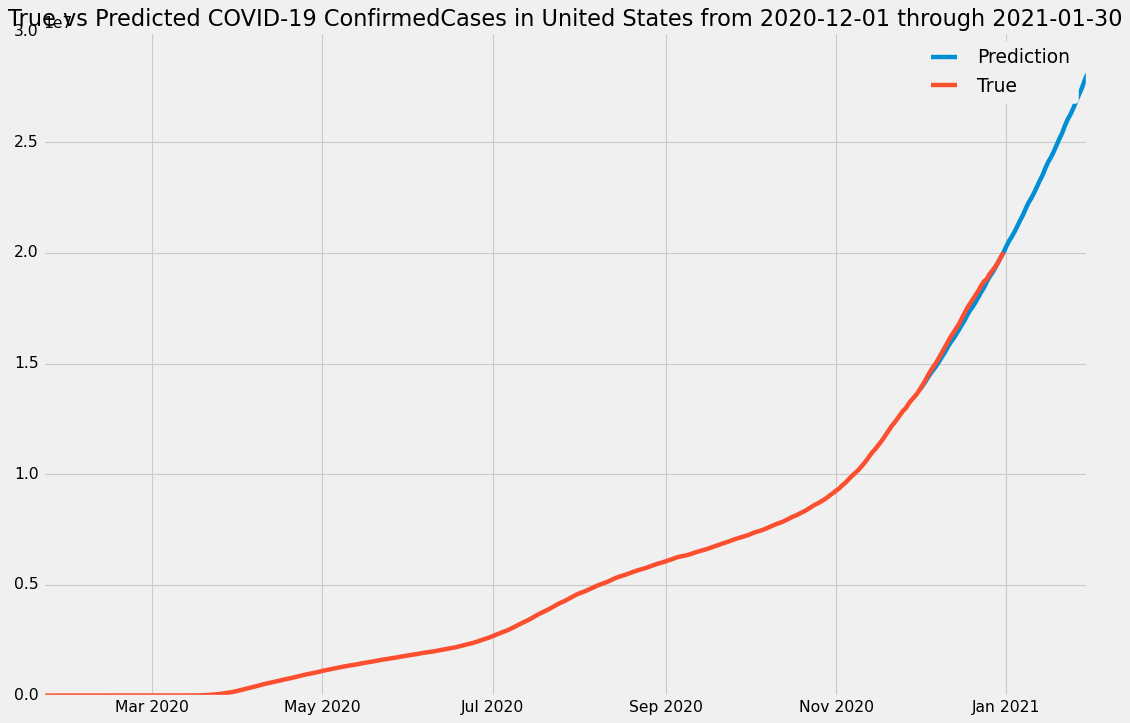

In [144]:
cbrt_train =  np.cbrt(train)

model2 = SARIMAX(cbrt_train, order = (0,2,0), seasonal_order = (3,2,1,7),
                                       freq = 'D')
fit_model2 = model2.fit(maxiter = 200, disp = False)
yhat = fit_model2.forecast(len(test)+30)**3
mpe = mean_percent_error(test,yhat)
print(f'mpe = {mpe}')

plt.plot(yhat, label='Prediction')
plt.plot(true, label='True')
plt.legend()
plt.title(f'True vs Predicted COVID-19 {prediction} in {region} from {yhat.index.date.min()} through {yhat.index.date.max()}') 
plt.savefig('SARIMA_prediction2021_01_05.png')
pickle.dump(fit_model2, open('SARIMAX_fit_model2.pickle', 'wb'))

The large error on Nov. 26th was because of Thanksgiving.  Fewer people were testing on Thanksgiving, or fewer people were working in the labs.  The increased errors between Nov. 9th and November 26th may be because of increased testing as people prepared to travel for the holiday.  Errors decrease again after this period.

## Let's test our model that did so well in December for January data.

In [ ]:
dfjan = get_covid_data().set_index('Date')


In [ ]:
prediction = 'ConfirmedCases'
region = 'United States'

dfjanusa = dfjan[(dfjan['Jurisdiction'] == 'NAT_TOTAL') & (dfjan['CountryName'] == region)][:-1]

true2 = dfjanusa[prediction]
true2.index.freq = 'd'
true2 = true2.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)

train2 = true2[true2.index < '2021-01-01']
test2 = true2[true2.index >= '2021-01-01']
train2

In [ ]:
cbrt_train2 =  np.cbrt(train2)

model3 = SARIMAX(cbrt_train2, order = (0,2,0), seasonal_order = (3,2,1,7),
                                       freq = 'D')
fit_model3 = model3.fit(maxiter = 200, disp = False)
yhat = fit_model3.forecast(len(test2))**3
mpe = mean_percent_error(test2,yhat)
print(f'mpe = {mpe}')

fig = go.Figure(layout_title_text = f'January Prediction from 2020 Data: Accuracy= {round((1-mpe)*100,2)}%',)
fig.add_trace(go.Scatter(x=true2.index,y=true2.values, name = 'Actual'))
fig.add_trace(go.Scatter(x=yhat.index,y=yhat.values, name = 'Predicted',
                         mode='lines'))
fig.update_layout(paper_bgcolor = 'LightSteelBlue')
fig.show()
pickle.dump(fit_model3, open('SARIMAX_fit_model3.pickle', 'wb'))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(yhat, label='Prediction')
plt.plot(true2[-len(yhat):], label='True')
plt.legend()
plt.tight_layout()
plt.title(f'True vs Predicted COVID-19 {prediction} in {region} from {yhat.index.date.min()} through {yhat.index.date.max()}') 
plt.savefig('SARIMA_prediction2021_01_19.png')